# Analysis of structural lysine deserts in models of the human proteome from the AlphaFold Protein Structure Database

# 1. Import libraries and read data

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
import argparse
import os
import re
import math
import pickle
import csv
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.DSSP import DSSP, dssp_dict_from_pdb_file
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
%matplotlib inline
from IPython.core.display import display, HTML

In [52]:
%%bash

mkdir -p results/charts

In [5]:
# We exclude noncontinuous AlphaFold2 models (cases of proteins longer than 2700 aa).
with open('data/Afold_structures/human_models_to_exclude.txt') as f:
    shattered_uniprots = [line.strip('\n') for line in f]

# Create ouptut file with column names if it does not exist
out_path = 'results/all_calc_structural_lysine_deserts.tsv'
if not os.path.exists(out_path):
    f=open(out_path, 'w')
    f.write('''UniProtID\tLength\tSeq_desert_150\tSeq_desert_0.5\tSeq_any_lys_cluster\tSeq_N_lys_cluster\tSeq_C_lys_cluster\tSeq_longest_desert\tSeq_longest_desert_start_index\tSeq_longest_desert_end_index\tSeq_desert_percentage\tStruct_residues_percentage_no_dssp_values\tStruct_no_exposed_aa\tStruct_total_SASA\tStruct_1_best_desert_length\tStruct_1_best_desert_length_percentage\tStruct_1_best_desert_among_all_exposed_percentage\tStruct_1_best_desert_among_total_SASA_percentage\tStruct_1_best_pymol_command\tStruct_2_best_desert_length\tStruct_2_best_desert_length_percentage\tStruct_2_best_desert_among_all_exposed_percentage\tStruct_2_best_desert_among_total_SASA_percentage\tStruct_2_best_pymol_command\tStruct_3_best_desert_length\tStruct_3_best_desert_length_percentage\tStruct_3_best_desert_among_all_exposed_percentage\tStruct_3_best_desert_among_total_SASA_percentage\tStruct_3_best_pymol_command\tSequence\n''')
    f.close()
    
# Define minimum sequence length
seq_min_length = 150
# Define maximum number of predicted Transmembrane Helices (TMH) in sequence
TMH_max = 2.0

# 2. Calculate lysine deserts

## Required data

* List of contacts (neighbors) for each residue (default contact cutoff = 4.0 A)
* Solvent accessible surface area (SASA) & relative solvent accessibility (RSA) calculated for each residue (residues with RSA below default cutoff = 0.2 are considered as buried)

## General Concept

```
Take each residue which fulfills both conditions: 
(i) it is not a lysine
(ii) is exposed
    For this residue take its neighbors (see -> NOTE below):
        If among these neighbors there is no exposed lysine
            Add only exposed ones to structural lysine desert path
            Take all their neighbors at once
                If among them there is no exposed lysine
                  Add only exposed ones to structural lysine desert path
                  Proceed as before unless appears an exposed lysine, then stop
                If there are no exposed neighbors
                  Stop (see -> NOTE 2 below)
```


> **_NOTE:_**  When iterating over neighbors, if some residue has no calculated SASA or RSA value due to dssp error, we omit it and proceed to the next one except for the lysine. If lysine has no calculated SASA or RSA value, we consider it as exposed and we break the desert.


> **_NOTE 2:_**  We intend to find longest, uninterrupted lysine-less regions among solvent-exposed residues **remaining in contact**. Therefore, buried residues may also break the lysine desert, as there may be no exposed neighbors to spread to.

> **_NOTE 3:_**  We use the models of human proteome from the AlphaFold Protein Structure Database - they consist of a single protein chain.


## Output
                
Table with lists of exposed residues constituting structural lysine desert with additional calculated features will be saved to the`results/structural_lysine_deserts_dataset.tsv`. We will refer to it hereafter as the output table.

#### Indexing

The output table is indexed by UniProt ID.

#### Columns description

The output table contains the following information:

| Column  | Description  |
|:--|:--|
|**Length**| Protein (chain) length obtained from the PDB file |
|**Seq_desert_150**| Binary value (0/1) describing if lysine desert min. 150 aa exists in sequence|
|**Seq_desert_0.5**| Binary value (0/1) describing if lysine desert min. 50% exists in sequence|
|**Seq_any_lys_cluster**| Binary value (0/1) describing occurrence of the lysine cluster (⌊80% of lysines⌋ located anywhere within 20% of the sequence) |
|**Seq_N_lys_cluster**| Binary value (0/1) describing occurrence of the lysine cluster at the N-terminus (⌊80% of lysines⌋  located within the first 20% of sequence)|
|**Seq_C_lys_cluster**|Binary value (0/1) describing occurrence of the lysine cluster at the C-terminus (⌊80% of lysines⌋  located within the last 20% of sequence)|
|**Seq_longest_desert**| Longest lysine-less region in the sequence |
|**Seq_longest_desert_start_index**| Start index of longest lysine-less region in the sequence| 
|**Seq_longest_desert_end_index**| End index of longest lysine-less region in the sequence| 
|**Seq_desert_percentage**| Fraction of the longest lysine-less region in the sequence|
|**Struct_residues_percentage_no_dssp_values**| Fractions of residues in chain that have no calculated SASA/RSA values due to the DSSP errors |
|**Struct_no_exposed_aa**| Number of exposed residues in the chain |
|**Struct_total_SASA**| Calculated total SASA for the chain |
|**Struct_1_best_desert_length**| Number of residues creating the 1st longest structural lysine desert in the chain |
|**Struct_1_best_desert_length_percentage**| Fraction of number of residues creating the 1st longest structural lysine desert in protein (value of protein (chain) length derived from the PDB file)|
|**Struct_1_best_desert_among_all_exposed_percentage**| Fraction of number of residues creating the 1st longest structural lysine desert among the exposed residues |
|**Struct_1_best_desert_among_total_SASA_percentage**| Fraction of SASA for residues creating the 1st longest structural lysine desert among protein's (chain's) total SASA|
|**Struct_1_best_pymol_command**|PyMOL command to visualize the 1st longest structural lysine desert |
|**Sequence**| Protein sequence derived directly from the structure|

---
> **_NOTE:_**  Same descriptions as `Struct_1_best_*` in apply to columns `Struct_2_best_*` and `Struct_3_best_*` which have information for the 2nd and 3rd longest structural lysine deserts, respectively.
---

### Display general concept of the algorithm

In [2]:
html = """
    Select a step:
    <input type="radio" name="images" onclick="show1();" checked>Step 1</input>
    <input type="radio" name="images" onclick="show2();">Step 2</input>
    <input type="radio" name="images" onclick="show3();">Step 3</input>
    <input type="radio" name="images" onclick="show4();">Step 4</input>
    <input type="radio" name="images" onclick="show5();">Step 5</input>
    <input type="radio" name="images" onclick="show6();">Step 6</input>
    <input type="radio" name="images" onclick="show7();">Step 7</input>
    <input type="radio" name="images" onclick="show8();">Step 8</input>
    <input type="radio" name="images" onclick="show9();">Step 9</input>

    <div id="image1">
      <img src="visualization/slajd1.png">
    </div>
    <div id="image2">
      <img src="visualization/slajd2.png">
    </div>
    <div id="image3">
      <img src="visualization/slajd3.png">
    </div>
    <div id="image4">
      <img src="visualization/slajd4.png">
    </div>
    <div id="image5">
      <img src="visualization/slajd5.png">
    </div>
    <div id="image6">
      <img src="visualization/slajd6.png">
    </div>
        <div id="image7">
      <img src="visualization/slajd7.png">
    </div>
    <div id="image8">
      <img src="visualization/slajd8.png">
    </div>
    <div id="image9">
      <img src="visualization/slajd9.png">
    </div>
    
    <script>
    function show1(){
      document.getElementById('image1').style.display ='block';
      document.getElementById('image2').style.display ='none';
      document.getElementById('image3').style.display ='none';
      document.getElementById('image4').style.display ='none';
      document.getElementById('image5').style.display ='none';
      document.getElementById('image6').style.display ='none';
      document.getElementById('image7').style.display ='none';
      document.getElementById('image8').style.display ='none';
      document.getElementById('image9').style.display ='none';
    }
    function show2(){
      document.getElementById('image1').style.display ='none';
      document.getElementById('image2').style.display ='block';
      document.getElementById('image3').style.display ='none';
      document.getElementById('image4').style.display ='none';
      document.getElementById('image5').style.display ='none';
      document.getElementById('image6').style.display ='none';
      document.getElementById('image7').style.display ='none';
      document.getElementById('image8').style.display ='none';
      document.getElementById('image9').style.display ='none';
    }
    function show3(){
      document.getElementById('image1').style.display ='none';
      document.getElementById('image2').style.display ='none';
      document.getElementById('image3').style.display ='block';
      document.getElementById('image4').style.display ='none';
      document.getElementById('image5').style.display ='none';
      document.getElementById('image6').style.display ='none';
      document.getElementById('image7').style.display ='none';
      document.getElementById('image8').style.display ='none';
      document.getElementById('image9').style.display ='none';
    }
    function show4(){
      document.getElementById('image1').style.display ='none';
      document.getElementById('image2').style.display ='none';
      document.getElementById('image3').style.display ='none';
      document.getElementById('image4').style.display ='block';
      document.getElementById('image5').style.display ='none';
      document.getElementById('image6').style.display ='none';
      document.getElementById('image7').style.display ='none';
      document.getElementById('image8').style.display ='none';
      document.getElementById('image9').style.display ='none';
    }
    function show5(){
      document.getElementById('image1').style.display ='none';
      document.getElementById('image2').style.display ='none';
      document.getElementById('image3').style.display ='none';
      document.getElementById('image4').style.display ='none';
      document.getElementById('image5').style.display ='block';
      document.getElementById('image6').style.display ='none';
      document.getElementById('image7').style.display ='none';
      document.getElementById('image8').style.display ='none';
      document.getElementById('image9').style.display ='none';
    }
    function show6(){
      document.getElementById('image1').style.display ='none';
      document.getElementById('image2').style.display ='none';
      document.getElementById('image3').style.display ='none';
      document.getElementById('image4').style.display ='none';
      document.getElementById('image5').style.display ='none';
      document.getElementById('image6').style.display ='block';
      document.getElementById('image7').style.display ='none';
      document.getElementById('image8').style.display ='none';
      document.getElementById('image9').style.display ='none';
    }
    function show7(){
      document.getElementById('image1').style.display ='none';
      document.getElementById('image2').style.display ='none';
      document.getElementById('image3').style.display ='none';
      document.getElementById('image4').style.display ='none';
      document.getElementById('image5').style.display ='none';
      document.getElementById('image6').style.display ='none';
      document.getElementById('image7').style.display ='block';
      document.getElementById('image8').style.display ='none';
      document.getElementById('image9').style.display ='none';
    }
    function show8(){
      document.getElementById('image1').style.display ='none';
      document.getElementById('image2').style.display ='none';
      document.getElementById('image3').style.display ='none';
      document.getElementById('image4').style.display ='none';
      document.getElementById('image5').style.display ='none';
      document.getElementById('image6').style.display ='none';
      document.getElementById('image7').style.display ='none';
      document.getElementById('image8').style.display ='block';
      document.getElementById('image9').style.display ='none';
    }
    function show9(){
      document.getElementById('image1').style.display ='none';
      document.getElementById('image2').style.display ='none';
      document.getElementById('image3').style.display ='none';
      document.getElementById('image4').style.display ='none';
      document.getElementById('image5').style.display ='none';
      document.getElementById('image6').style.display ='none';
      document.getElementById('image7').style.display ='none';
      document.getElementById('image8').style.display ='none';
      document.getElementById('image9').style.display ='block';
    }
    show1()
    </script>
"""
display(HTML(html))

### What if we do not know if a residue is solvent-exposed?

In [3]:
html2 = """
    Select a step:
    <input type="radio" name="images" onclick="show1A();" checked>Step 1</input>
    <input type="radio" name="images" onclick="show2A();">Step 2</input>
    <input type="radio" name="images" onclick="show3A();">Step 3</input>
    <input type="radio" name="images" onclick="show4A();">Step 4</input>
    <input type="radio" name="images" onclick="show5A();">Step 5</input>
    <input type="radio" name="images" onclick="show6A();">Step 6</input>
    <input type="radio" name="images" onclick="show7A();">Step 7</input>


    <div id="image1A">
      <img src="visualization/slajd10.png">
    </div>
    <div id="image2A">
      <img src="visualization/slajd11.png">
    </div>
    <div id="image3A">
      <img src="visualization/slajd12.png">
    </div>
    <div id="image4A">
      <img src="visualization/slajd13.png">
    </div>
    <div id="image5A">
      <img src="visualization/slajd14.png">
    </div>
    <div id="image6A">
      <img src="visualization/slajd15.png">
    </div>
        <div id="image7A">
      <img src="visualization/slajd16.png">
    </div>
    
    <script>
    function show1A(){
      document.getElementById('image1A').style.display ='block';
      document.getElementById('image2A').style.display ='none';
      document.getElementById('image3A').style.display ='none';
      document.getElementById('image4A').style.display ='none';
      document.getElementById('image5A').style.display ='none';
      document.getElementById('image6A').style.display ='none';
      document.getElementById('image7A').style.display ='none';
    }
    function show2A(){
      document.getElementById('image1A').style.display ='none';
      document.getElementById('image2A').style.display ='block';
      document.getElementById('image3A').style.display ='none';
      document.getElementById('image4A').style.display ='none';
      document.getElementById('image5A').style.display ='none';
      document.getElementById('image6A').style.display ='none';
      document.getElementById('image7A').style.display ='none';
    }
    function show3A(){
      document.getElementById('image1A').style.display ='none';
      document.getElementById('image2A').style.display ='none';
      document.getElementById('image3A').style.display ='block';
      document.getElementById('image4A').style.display ='none';
      document.getElementById('image5A').style.display ='none';
      document.getElementById('image6A').style.display ='none';
      document.getElementById('image7A').style.display ='none';
    }
    function show4A(){
      document.getElementById('image1A').style.display ='none';
      document.getElementById('image2A').style.display ='none';
      document.getElementById('image3A').style.display ='none';
      document.getElementById('image4A').style.display ='block';
      document.getElementById('image5A').style.display ='none';
      document.getElementById('image6A').style.display ='none';
      document.getElementById('image7A').style.display ='none';
    }
    function show5A(){
      document.getElementById('image1A').style.display ='none';
      document.getElementById('image2A').style.display ='none';
      document.getElementById('image3A').style.display ='none';
      document.getElementById('image4A').style.display ='none';
      document.getElementById('image5A').style.display ='block';
      document.getElementById('image6A').style.display ='none';
      document.getElementById('image7A').style.display ='none';
    }
    function show6A(){
      document.getElementById('image1A').style.display ='none';
      document.getElementById('image2A').style.display ='none';
      document.getElementById('image3A').style.display ='none';
      document.getElementById('image4A').style.display ='none';
      document.getElementById('image5A').style.display ='none';
      document.getElementById('image6A').style.display ='block';
      document.getElementById('image7A').style.display ='none';
    }
    function show7A(){
      document.getElementById('image1A').style.display ='none';
      document.getElementById('image2A').style.display ='none';
      document.getElementById('image3A').style.display ='none';
      document.getElementById('image4A').style.display ='none';
      document.getElementById('image5A').style.display ='none';
      document.getElementById('image6A').style.display ='none';
      document.getElementById('image7A').style.display ='block';
    }

    show1A()
    </script>
"""
display(HTML(html2))

### What if there are no solvent-exposed contacts?

In [4]:
html3 = """
    Select a step:
    <input type="radio" name="images" onclick="show1B();" checked>Step 1</input>
    <input type="radio" name="images" onclick="show2B();">Step 2</input>
    <input type="radio" name="images" onclick="show3B();">Step 3</input>
    <input type="radio" name="images" onclick="show4B();">Step 4</input>
    <input type="radio" name="images" onclick="show5B();">Step 5</input>


    <div id="image1B">
      <img src="visualization/slajd17.png">
    </div>
    <div id="image2B">
      <img src="visualization/slajd18.png">
    </div>
    <div id="image3B">
      <img src="visualization/slajd19.png">
    </div>
    <div id="image4B">
      <img src="visualization/slajd20.png">
    </div>
    <div id="image5B">
      <img src="visualization/slajd21.png">
    </div>

    
    <script>
    function show1B(){
      document.getElementById('image1B').style.display ='block';
      document.getElementById('image2B').style.display ='none';
      document.getElementById('image3B').style.display ='none';
      document.getElementById('image4B').style.display ='none';
      document.getElementById('image5B').style.display ='none';
    }
    function show2B(){
      document.getElementById('image1B').style.display ='none';
      document.getElementById('image2B').style.display ='block';
      document.getElementById('image3B').style.display ='none';
      document.getElementById('image4B').style.display ='none';
      document.getElementById('image5B').style.display ='none';
    }
    function show3B(){
      document.getElementById('image1B').style.display ='none';
      document.getElementById('image2B').style.display ='none';
      document.getElementById('image3B').style.display ='block';
      document.getElementById('image4B').style.display ='none';
      document.getElementById('image5B').style.display ='none';
    }
    function show4B(){
      document.getElementById('image1B').style.display ='none';
      document.getElementById('image2B').style.display ='none';
      document.getElementById('image3B').style.display ='none';
      document.getElementById('image4B').style.display ='block';
      document.getElementById('image5B').style.display ='none';
    }
    function show5B(){
      document.getElementById('image1B').style.display ='none';
      document.getElementById('image2B').style.display ='none';
      document.getElementById('image3B').style.display ='none';
      document.getElementById('image4B').style.display ='none';
      document.getElementById('image5B').style.display ='block';
    }

    show1B()
    </script>
"""
display(HTML(html3))

## 2.1. Define parametres

In [2]:
afold_dataset = 'data/Afold_structures/H_sapiens' # path to directory with downloaded and ungzipped PDB files from the AlphaFoldProtein Structure Database

desert_min_lengths = [150, 0.5] # float or integer, so we use different approach to find sequences specified % of lysine deserts or sequences with lysine desert of greater than declared length
lysine_cluster_fraction = 0.2 # maximal fraction of seq length (in any place of sequence) to contain at least 80% of all lysines
N_term_end_fraction = 0.2 # first 20% of sequence is considered N-term
C_term_end_fraction = 0.8 # last 80% of sequence is considered C-term

CUTOFF = 4.0 # maximum distance between residues to be considered as in contact
EXPOSED_CUTOFF = 0.2 # RSA minimum value for residue to be considered as exposed

aa_converter = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
                'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
                'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
                'ALA': 'A', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M', 
                'CAS': 'C', 'N7P': 'P', 'CSX': 'C', 'SEP': 'S', 'PHD': 'D',
                'SAH': 'C', 'MCS': 'C', 'PVH': 'H', 'MSE': 'M', 'CAF': 'C',
                'CSD': 'C', 'CSO': 'C', 'LED': 'L', 'PCA': 'Q', 'PTR': 'Y',
                'TPO': 'T', 'NCB': 'A', 'MLY': 'K', 'CME': 'C', 'HYP': 'P'}

## 2.2. Define functions

In [29]:
class ProcessSeq():

    def __init__(self, seq):
        
        self.seq = seq
                
    def __check_lysine_cluster(self):
        """Check if lysine cluster region occurs in sequence. Cluster is defined if at least 80% of sequence lysines are within 20% sequence length

        :return: total lysine region cluster fraction, N-term lysine region cluster fraction, C-term lysine region cluster fraction
        :rtype: int, int, int
         """
            
        total_cluster_no = 0
        N_cluster_no = 0
        C_cluster_no = 0

        left_idx = []
        right_idx = []
        cluster_max_length = lysine_cluster_fraction * len(self.seq)

        only_lysine = ''.join(['1' if aa == 'K' else '0' for aa in self.seq])
        only_lysine_indices = [match.start() for match in re.finditer('1', only_lysine)]

        if len(only_lysine_indices) > 2:
            for i in range(math.ceil(len(only_lysine_indices)/5)+1): # divided by 5 = 20% so 80% of lysines have to be present in cluster, change in both places for 4 if you want 75% of all lysines to be present in cluster
                for j in range(1,math.ceil(len(only_lysine_indices)/5)+2-i):
                    if only_lysine_indices[-j] - only_lysine_indices[i] < cluster_max_length:
                        cluster = len(only_lysine_indices[i:-j]) + 1
                        left_idx.append(only_lysine_indices[i])
                        right_idx.append(only_lysine_indices[-j])

            if len(right_idx) > 0:

                for right, left in zip(right_idx, left_idx):
                    if right < N_term_end_fraction * len(self.seq):
                        N_cluster_no += 1
                        break
                    elif left > C_term_end_fraction * len(self.seq):
                        C_cluster_no += 1
                        break

                total_cluster_no += 1

        return total_cluster_no, N_cluster_no, C_cluster_no  
                 
    def find_lysine_deserts_by_sequence_fasta(self, desert_min_length):
        """Find lysine-less regions considering only sequence information in fasta format and given desert length
        
        :param desert_min_length: minimal lysine-less region length or sequence fraction to consider lysine desert
        :rtype desert_min_length: int or float
        :return: 0/1 lysine-less region existence of a given length, 0/1 lysine cluster existence anywhere in sequence, 0/1 lysine cluster existence at N-end, 0/1 lysine cluster existence at C-end, length of longest lysine-less region,longest lysine-less region start index, longest lysine-less region end index, percentage of lysine-less region in sequence
        :rtype: list
        """
            
        desert_counter = 0

        seq_filtered = ''.join(['1' if aa != 'K' else '0' for aa in self.seq])
        desert_indices = [(match.start(), match.end()) for match in re.finditer('1+', seq_filtered)] # get lysine-less sequence chunks
        desert_indices_lengths = [i[1] - i[0] for i in desert_indices]

        desert_indices_filtered = []
        desert_lengths_filtered = []
            
        if type(desert_min_length) != int:
            desert_min_calc = int(math.ceil(desert_min_length * len(self.seq)))
        else:
            desert_min_calc = desert_min_length

        for indice in desert_indices:

            start, end = indice
            length = int(end) - int(start)
            if length >= desert_min_calc:
                desert_indices_filtered.append((start, end))
                desert_lengths_filtered.append(int(end)-int(start))

        if desert_indices_filtered:
            desert_counter = 1
            
        total_cluster_no, N_cluster_no, C_cluster_no = self.__check_lysine_cluster()

        return [desert_counter, total_cluster_no, N_cluster_no, C_cluster_no, max(desert_indices_lengths), desert_indices[desert_indices_lengths.index(max(desert_indices_lengths))][0], desert_indices[desert_indices_lengths.index(max(desert_indices_lengths))][1], round((max(desert_indices_lengths)/len(self.seq))*100,2)]      

In [33]:
def measure_distance(v1, v2):
    """Calculates distance between two vectors
    
    :param v1: vector 1 coordinates
    :param v2: vector 2 coordinates
    :type v1: tuple, numpy.ndarray
    :type v2: tuple, numpy.ndarray
    :return: distance between two vectors
    :rtype: numpy.float64
    """
    
    return np.round(np.linalg.norm(v1 - v2), 3)

def count_residues_prepare_neighbors(structure):
    """Calculate number of residues in selected chains and prepare keys in neighbors dictionary
    
    :param structure: structure of first model from pdb file
    :type structure: Bio.PDB.Model.Model
    :return: calculated number of residues in chain and initialized neighbors dictionary with residue names in form of 3-letter-residue-code:residue-number:chainID
    :rtype: int, dict
    """
    
    RES_no = 0
    neighbors = {}
    
    for chain in structure:
        
                
        for el in chain.get_residues():                
            RES_no +=1
            name = aa_converter[el.get_resname()] + ':' + str(el.get_id()[1]) + ':' + str(chain.get_id())
            neighbors[name] = set()
                
    return RES_no, neighbors

def calculate_contact_matrix(structure, name):
    """Calculate contact matrix residue vs residue
    
    :param structure: structure of first model from pdb file
    :type structure: Bio.PDB.Model.Model
    :return: distance matrix, dictionary of contacts (neighbors) for each residue, number of residues in chain, sequence obtained from chain, dictionary that maps residue numbers to their indices in sequence
    :rtype: list, dict, int, dict, str, dict
    """
    
    MATRIX = [] # output contacts matrix
    Protein_residues = []
    calculated = []
    sequence = '' # get sequence from structure
    
    PROTEIN_LENGTH, neighbors = count_residues_prepare_neighbors(structure)
    
    idx1 = 0
    for chain in structure:
        
    
        residues_list = list(chain.get_residues())
        
        renum_index = 0
    
        for residue1 in range(len(residues_list)):
                            
            res1_Num = str(residues_list[residue1].get_id()[1])
            
            renum_index += 1
            
            res1_Chain = str(chain.get_id())
            res1_Name = aa_converter[residues_list[residue1].get_resname()]
            sequence += res1_Name
            
            res1_complete_id = res1_Name + ':' + str(res1_Num) + ':' + str(res1_Chain)
            
            Protein_residues.append(res1_complete_id)
            
            calculated.append(res1_complete_id)
            
            result = [None] * PROTEIN_LENGTH
            
            idx2 = 0
            for chain2 in structure:
                
                residues_list2 = list(chain2.get_residues())
                
                for residue2 in range(len(residues_list2)):
                    
                    res2_Num = str(residues_list2[residue2].get_id()[1])
                    res2_Chain = str(chain2.get_id())
                    res2_Name = aa_converter[residues_list2[residue2].get_resname()]
                    
                    res2_complete_id = res2_Name + ':' + str(res2_Num) + ':' + str(res2_Chain)
            
                    ### To speed up and not calculate same interctions twice (res1 vs. res2 & res2 vs. res1) ###
                
                    if res2_Num == res1_Num and res2_Chain == res1_Chain: # same residue
                        result[idx2] = 0.000
                        idx2 += 1
                        continue
                    
                    if res2_complete_id in calculated:
                        if res2_Num == res1_Num and res2_Chain == res1_Chain: # same residue
                            result[idx2] = 0.000
                        else:
                            result[idx2] = MATRIX[idx2][idx1]
                        idx2 += 1
                        continue
                        
                    ### Calculate shortest distance between two residues
                    
                    shortest_distance = 1000000
                    res1_atoms = [atom for atom in residues_list[residue1]]
                    res2_atoms = [atom for atom in residues_list2[residue2]]

                    for i in range(len(res1_atoms)):
                        if res1_atoms[i].get_id() != 'H':
                            for j in range(len(res2_atoms)):
                                if res2_atoms[j].get_id() != 'H':

                                    distance = measure_distance(res1_atoms[i].get_vector(), res2_atoms[j].get_vector())

                                    if distance < shortest_distance:
                                        shortest_distance = distance

                    result[idx2] = shortest_distance

                    if shortest_distance <= CUTOFF:
                        neighbors[res1_complete_id].add(res2_complete_id)
                        neighbors[res2_complete_id].add(res1_complete_id)
                        
                    idx2 += 1
                    
            idx1 += 1
            MATRIX.append(result)

    assert len(Protein_residues) == PROTEIN_LENGTH
    
    ### If you want to save distance matrix ###
    
#     df = pd.DataFrame.from_records(MATRIX, columns = Protein_residues).rename(lambda x: Protein_residues[x])
#     df.to_csv('dist_matrix_{}.csv'.format(name), sep='\t')

    return MATRIX, neighbors, PROTEIN_LENGTH, sequence

def no_exposed_lysine(res_set):
    """Check if on the given list of residues there is exposed lysine
    :param res_set: set of residue IDs
    :type res_set: set
    :return: True if there is no exposed lysine in the residue list, False otherwise
    :rtype: bool
    """
    
    OK = True

    if len(res_set) == 0:
        OK = False
    
    for i in res_set:
        aa = i.split(':')[0]
        if aa == 'K':
            
            try:
                exposure = sasa_rsa_dict[i][1]
            except KeyError: # lysine RSA was not calculated due to dssp error, we assume it it exposed
                return False
            
            if exposure > EXPOSED_CUTOFF:
                OK = False
    return OK

def find_structural_deserts(neighbors, sasa_rsa_dict):
    """Find all lysine-less surfaces starting from each residue
    :param neighbors: dictionary with residues as keys and residues in contacts with them as values
    :type neigbors: dict
    :return: dictionary of longest lysine-less surfaces stretching around each residue
    :rtype: dict
    """
    
    paths = {}

    for key in neighbors.keys():
        
        try:
            RSA_value = sasa_rsa_dict[key][1]
        except KeyError:
            continue
            
        if RSA_value <  EXPOSED_CUTOFF: # do not start with buried aa
            continue
        if key.split(':')[0] == 'K': # do not start with exposed lysine
            continue

        n = neighbors[key]
        analyzed_neighbors = set()
        analyzed_neighbors.add(key)
        
        paths[key] =[sasa_rsa_dict[key][0],set()]
        paths[key][1].add(key)

        while no_exposed_lysine(n):

            n2 = set()

            for neigh in n:
                try:
                    RSA_value_neigh = sasa_rsa_dict[neigh][1]
                except KeyError:
                    continue
                
                if RSA_value_neigh >  EXPOSED_CUTOFF: # only for exposed neighbors
                    if neigh not in paths[key][1]:
                        paths[key][0] += sasa_rsa_dict[neigh][0] # add SASA for new neighbor

                    paths[key][1].add(neigh) # add neighbor to paths set
                    analyzed_neighbors.add(neigh)
                    new_n = neighbors[neigh] # list of neighbors of that neighbor

                    for nn in new_n: # for neighbor of current neighbor
                        try:
                            RSA_value_neigh_neigh = sasa_rsa_dict[nn][1]
                        except KeyError:
                            if nn.split(':')[0] == 'K': # lysine with uncalculated RSA, add to n2 so no_exposed_lysine() will break such desert, as we assume K with unknown SASA/RSA is exposed
                                n2.add(nn)
                            continue
                        
                        if RSA_value_neigh_neigh >  EXPOSED_CUTOFF and nn not in analyzed_neighbors:
                            n2.add(nn) # if exposed, add it to set of all neighbors of current neighbors
                
            n = n2 # change n to set of all neighbors of current neighbors
    
    return paths

## 2.3. Run analysis

In [ ]:
### Read all so far calculated PDB IDs and make list of them (in case analysis was interrupted) ###

f=open(out_path, 'r')
all_calc= f.readlines()
f.close()

all_calc_list = []
for line in all_calc:
    calc_pdb_id = line.split('\t')[0]
    all_calc_list.append(calc_pdb_id)
    
### Read & iterate over dataset of all human Afold models ###

for filename in os.listdir(afold_dataset):

    if filename == '.DS_Store': 
        continue

    pdb_path = os.path.join(afold_dataset, filename)
    uniprot = filename.split('-')[1]
    
    if uniprot in shattered_uniprots: 
        continue
       
    ### Check PDB IDs of already calculated structures to not repeat calculations ###
    if uniprot in all_calc_list:
        continue    
    
    ### Calculate distance matrix ###
    
    p = PDBParser(PERMISSIVE=1)
    
    structure = p.get_structure('', pdb_path)       
    model = structure[0] # take only first model in each pdb
    matrix, neighbors, chain_length, sequence = calculate_contact_matrix(model, uniprot)
    
    ### Calculate lysine desert on sequence ###
        
    s = ProcessSeq(sequence) # search for lysine desert on actual sequence of the structure

    score = [uniprot, len(sequence)]
    
    for desert_length in desert_min_lengths:
        result = s.find_lysine_deserts_by_sequence_fasta(desert_length)

        score.append(result[0])
        
        if desert_length == 0.5: # last desert type
            score.extend(result[1:])
            desert_start = result[5]
            desert_end = result[6]
            
    ### Calculate RSA ###
    
    try:
        dssp_rsa = DSSP(model, pdb_path)
    except Exception: # if dssp returns error
        continue
    rsa_residues = list(dssp_rsa)

    ### Calculate SASA ##
    
    dssp_sasa = dssp_dict_from_pdb_file(pdb_path)

    ### Create dict with residue id as key and tuple (SASA, RSA) ###
    
    sasa_rsa_dict = {}

    c=0 # pointer for corresponding RSA value position
    for key in dssp_sasa[0].keys():
        aa = dssp_sasa[0][key][0]

        name = '{}:{}:{}'.format(aa, key[1][1], key[0])

        if name in neighbors.keys():
            if type(dssp_sasa[0][key][2]) is str or type(rsa_residues[c][3]) is str: #SASA or RSA for residue was not properly calculated
                c+= 1
                continue

            sasa_rsa_dict[name] = (dssp_sasa[0][key][2], round(rsa_residues[c][3],3))
            c+= 1
                  
    ### Sum total SASA and number of exposed aa ###
    
    total_SASA = 0
    no_exposed = 0

    for key in sasa_rsa_dict:
        total_SASA += sasa_rsa_dict[key][0]
        if sasa_rsa_dict[key][1] > 0.2:
            no_exposed += 1

    score.append(round(((len(sequence)-len(sasa_rsa_dict))/len(sequence))*100, 2))
    score.append(no_exposed)
    score.append(total_SASA)
    
    ### Find structural lysine deserts starting from each residue  ###
    
    paths = find_structural_deserts(neighbors, sasa_rsa_dict)
    
    ### Sort structural deserts according to their lengths  ###
    
    lenghts = []
    
    for k in paths.keys():
        lenghts.append((k, len(paths[k][1])))
        
    sorted_by_structural_desert_length = sorted(lenghts, key=lambda tup: tup[1], reverse=True)
    
    ### Save results from 3 longest structural lysine deserts with distinct SASA values ###
    
    best_results = 0
    SASA_percentages = []
    
    for i in range(len(sorted_by_structural_desert_length)):
        
        if best_results < 3:
            try:
                SASA_percentage = round((paths[sorted_by_structural_desert_length[i][0]][0]/total_SASA)*100,2)

                if SASA_percentage not in SASA_percentages: # only if SASA percentage is different than in previous results
                    SASA_percentages.append(SASA_percentage)
                    best_results += 1

                    structural_desert_length = len(paths[sorted_by_structural_desert_length[i][0]][1])
                    structural_desert_length_percentage = round((len(paths[sorted_by_structural_desert_length[i][0]][1])/chain_length)*100,2)
                    exposed_percentage = round((len(paths[sorted_by_structural_desert_length[i][0]][1])/no_exposed)*100, 2)

                    desert_coverage = 0
                    pymol_command = 'select chain A and resi '

                    for aa in paths[sorted_by_structural_desert_length[i][0]][1]:
                        res_no = aa.split(':')[1]
                        pymol_command += '{}+'.format(res_no)
                        desert_coverage += 1

                    pymol_command = pymol_command[:-1]
                    score.extend([structural_desert_length, structural_desert_length_percentage, exposed_percentage, SASA_percentage, pymol_command])
                
                else:
                    continue

            except IndexError:
                continue
        
        else:
            break
            
    if best_results < 3: # less than 3 best results were saved, rare case
        for i in range(3 - best_results):
            score.extend([None, None, None, None, None])
                
    score.extend([sequence])
       
    ### Save results for each PDB chain to tsv file ### 
    
    with open(out_path,'a') as result_file:
        wr = csv.writer(result_file, delimiter='\t')
        wr.writerow(score)

# 3. Analyze the results

## 3.1. Read output dataset

In [6]:
# Read output table
df = pd.read_csv('results/all_calc_structural_lysine_deserts.tsv', sep='\t')
df.head(5)

,UniProtID,Length,Seq_desert_150,Seq_desert_0.5,Seq_any_lys_cluster,Seq_N_lys_cluster,Seq_C_lys_cluster,Seq_longest_desert,Seq_longest_desert_start_index,Seq_longest_desert_end_index,Seq_desert_percentage,Struct_residues_percentage_no_dssp_values,Struct_no_exposed_aa,Struct_total_SASA,Struct_1_best_desert_length,Struct_1_best_desert_length_percentage,Struct_1_best_desert_among_all_exposed_percentage,Struct_1_best_desert_among_total_SASA_percentage,Struct_1_best_pymol_command,Struct_2_best_desert_length,Struct_2_best_desert_length_percentage,Struct_2_best_desert_among_all_exposed_percentage,Struct_2_best_desert_among_total_SASA_percentage,Struct_2_best_pymol_command,Struct_3_best_desert_length,Struct_3_best_desert_length_percentage,Struct_3_best_desert_among_all_exposed_percentage,Struct_3_best_desert_among_total_SASA_percentage,Struct_3_best_pymol_command,Sequence
0,Q9Y5M8,271,0,0,0,0,0,55,77,132,20.30,0.0,182,18568,54,19.93,29.67,31.38,select chain A and resi 34+9+28+37+46+53+13+20+16+29+8+44+18+39+45+51+52+4+2+19+47+36+41+49+23+35+33+17+27+7+26+31+30+1+14+15+48+11+22+12+3+24+25+43+40+54+5+10+6+50+21+32+42+38,53.0,19.56,29.12,30.09,select chain A and resi 34+9+28+37+46+53+13+20+16+29+8+44+18+39+45+51+52+4+2+19+47+36+41+49+23+35+33+17+27+7+26+31+30+14+15+48+11+22+12+3+24+25+43+40+54+5+10+6+50+21+32+42+38,51.0,18.82,28.02,28.92,select chain A and resi 34+28+9+37+46+53+13+20+16+29+8+44+18+39+45+51+52+4+19+47+36+41+49+23+35+33+17+27+7+26+31+30+14+15+48+11+22+12+24+25+43+40+54+5+10+6+50+21+32+42+38,MASADSRRVADGGGAGGTFQPYLDTLRQELQQTDPTLLSVVVAVLAVLLTLVFWKLIRSRRSSQRAVLLVGLCDSGKTLLFVRLLTGLYRDTQTSITDSCAVYRVNNNRGNSLTLIDLPGHESLRLQFLERFKSSARAIVFVVDSAAFQREVKDVAEFLYQVLIDSMGLKNTPSFLIACNKQDIAMAKSAKLIQQQLEKELNTLRVTRSAAPSTLDSSSTAPAQLGKKGKEFEFSQLPLKVEFLECSAKGGRGDVGSADIQDLEKWLAKIA
1,Q96M91,514,0,0,0,0,0,21,152,173,4.09,0.0,514,56083,20,3.89,3.89,3.56,select chain A and resi 165+171+169+172+158+168+156+153+167+166+161+159+154+163+164+170+162+160+157+155,17.0,3.31,3.31,3.16,select chain A and resi 115+101+113+108+116+109+103+105+117+106+110+111+102+104+107+114+112,17.0,3.31,3.31,3.25,select chain A and resi 115+113+108+116+118+109+103+117+105+111+110+106+102+104+107+114+112,MYSQRFGTVQREVKGPTPKVVIVRSKPPKGQGAEHHLERIRRSHQKHNAILASIKSSERDRLKAEWDQHNDCKILDSLVRARIKDAVQGFIINIEERRNKLRELLALEENEYFTEMQLKKETIEEKKDRMREKTKLLKEKNEKERQDFVAEKLDQQFRERCEELRVELLSIHQKKVCEERKAQIAFNEELSRQKLVEEQMFSKLWEEDRLAKEKREAQEARRQKELMENTRLGLNAQITSIKAQRQATQLLKEEEARLVESNNAQIKHENEQDMLKKQKAKQETRTILQKALQERIEHIQQEYRDEQDLNMKLVQRALQDLQEEADKKKQKREDMIREQKIYHKYLAQRREEEKAQEKEFDRILEEDKAKKLAEKDKELRLEKEARRQLVDEVMCTRKLQVQEKLQREAKEQEERAMEQKHINESLKELNCEEKENFARRQRLAQEYRKQLQMQIAYQQQSQEAEKEEKRREFEAGVAANKMCLDKVQEVLSTHQVLPQNIHPMRKACPSKLPP
2,Q9H2C1,402,1,0,0,0,0,163,239,402,40.55,0.0,361,43262,150,37.31,41.55,46.03,select chain A and resi 394+260+379+387+390+402+255+370+264+281+41+307+278+350+303+271+349+288+286+376+284+263+311+262+339+295+254+285+345+272+297+377+329+372+360+364+397+356+373+399+259+353+351+275+261+338+323+322+371+333+354+305+396+291+269+383+382+362+334+302+365+266+400+348+327+368+280+330+343+326+268+267+342+318+386+389+298+292+335+381+317+282+290+392+363+274+359+293+287+314+385+375+367+340+378+344+352+393+384+346+315+358+276+388+279+341+312+304+366+273+336+283+308+331+300+391+325+319+332+299+258+309+361+395+310+374+296+321+256+324+320+289+347+257+294+357+380+328+277+265+398+369+270+301+401+306+355+337+313+316,149.0,37.06,41.27,45.79,select chain A and resi 394+260+379+387+390+402+255+370+264+281+41+307+278+350+303+271+349+288+286+376+284+263+311+262+339+295+254+285+345+272+297+377+329+372+360+364+397+356+373+399+259+353+351+275+261+338+323+322+371+333+354+305+396+291+269+383+382+362+334+302+365+266+400+348+327+368+280+330+343+326+268+267+342+318+386+389+298+292+335+381+317+282+290+392+363+274+359+293+287+314+385+375+367+340+378+344+352+393+384+346+315+358+276+388+279+341+312+304+366+273+336+283+308+331+300+391+325+319+332+299+258+309+361+395+310+374+296+321+256+324+320+289+347+257+294+357+380

## 3.2. Merge with the lysine desert dataset calculated based on the human reference proteome from the UniProt database

Thanks to this step we will exclude any AlphaFold2 models that either do not occurr in the  human reference proteome from the UniProt database or differ in protein sequence

In [7]:
df_human = pd.read_csv('../Human_proteome_detailed_analysis/results/lysine_deserts_human_proteome.tsv.gz', sep='\t')
df_human[['Lysine desert sequence fraction']] = df_human[['Lysine desert sequence fraction']].astype(float)
merged = df_human.merge(df, on=['UniProtID', 'Sequence'], how='left')

## 3.3. Select proper hits

Sometimes the DSSP software used to calculate SASA/RSA values failed. Therefore we select rows for which less than 5% of residues has no calculated SASA/RSA values.

Additionaly, similarly as in other analyses, we select proteins > 150 aa and with the predicted number of transmembrane helices by the TMHMM-2.0 software ≤ 2.

In [8]:
analyze = merged[(merged['Struct_residues_percentage_no_dssp_values'] < 5) &
                (merged['Sequence length'] >= seq_min_length) &
                (merged["NumTMH"] <= TMH_max)]

## 3.4. Compare sequential lysine desert with the structural lysine desert


Plot fraction of lysine desert in sequence against fraction of structural lysine desert among only exposed residues. 

Only for first best (longest) structural lysine desert.

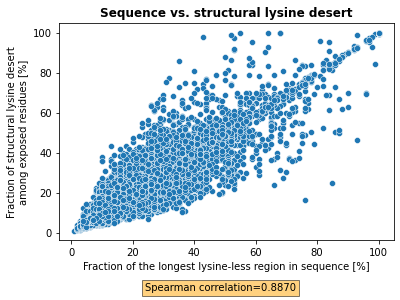

In [9]:
g = sns.scatterplot(data=analyze, x="Lysine desert sequence fraction", y="Struct_1_best_desert_among_all_exposed_percentage" );

g.set_title("Sequence vs. structural lysine desert", weight="bold")
g.set_xlabel("Fraction of the longest lysine-less region in sequence [%]")
g.set_ylabel("Fraction of structural lysine desert\namong exposed residues [%]")
g.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]);
g.set_xticklabels(['0','20',  '40', '60', '80',  '100'])

fig = g.get_figure()
corr, _ = spearmanr(analyze["Lysine desert sequence fraction"], analyze["Struct_1_best_desert_among_all_exposed_percentage"]);
plt.figtext(0.5, -0.05, "Spearman correlation=%.4f" % corr, ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":3})

fig.savefig(f"results/charts/Sequence vs. structural lysine desert.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

## 3.4. Compare coverage of structural deserts in sequence deserts

### 3.4.1. Prepare new columns in the dataset

We will create a new column that holds value of ratio number of common residues between sequence/structural desert for each best structural lysine desert in the dataset.

Only for first best (longest) structural lysine desert.

In [10]:
df_struct_seq = analyze.copy()
best_struct_desert_how_many_aa_in_best_seq_desert = []

for index, value in df_struct_seq.iterrows():
    no_common = 0
    
    desert_seq_range = list(range(value[29],value[30]))

    desert_struct_one_best_pymol = value[57]
    desert_struct_one_best_pymol = desert_struct_one_best_pymol.split('resi ')[1].split('+')
    for i in desert_struct_one_best_pymol:
        if int(i)-1 in desert_seq_range:
            no_common += 1
    
    best_struct_desert_how_many_aa_in_best_seq_desert.append(round(no_common/len(desert_seq_range), 2))

df_struct_seq['best_struct_desert_how_many_aa_in_best_seq_desert'] = best_struct_desert_how_many_aa_in_best_seq_desert

### 3.4.2. Plot coverage of structural lysine deserts within sequence lysine deserts

Only for first best (longest) structural lysine desert.

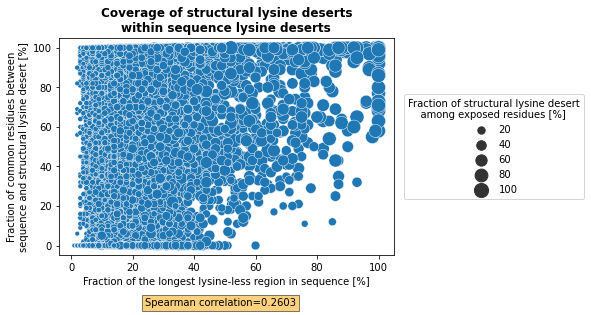

In [11]:
g = sns.scatterplot(data=df_struct_seq, x="Lysine desert sequence fraction", y="best_struct_desert_how_many_aa_in_best_seq_desert",
                    size="Struct_1_best_desert_among_all_exposed_percentage", sizes=(20, 200)
                 );

g.set_title("Coverage of structural lysine deserts\nwithin sequence lysine deserts", weight="bold")
g.set_xlabel("Fraction of the longest lysine-less region in sequence [%]")
g.set_ylabel("Fraction of common residues between\nsequence and structural lysine desert [%]")
g.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]);
g.set_xticklabels(['0','20',  '40', '60', '80',  '100']);
g.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]);
g.set_yticklabels(['0','20',  '40', '60', '80',  '100']);

g.legend(title='Fraction of structural lysine desert\n    among exposed residues [%]', loc='center', 
         bbox_to_anchor=(1.3, 0.5))

fig = g.get_figure()
corr, _ = spearmanr(df_struct_seq["Lysine desert sequence fraction"], df_struct_seq["best_struct_desert_how_many_aa_in_best_seq_desert"]);
plt.figtext(0.5, -0.05, "Spearman correlation=%.4f" % corr, ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":3})
plt.savefig(f"results/charts/Coverage of structural lysine deserts within sequence lysine deserts.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()